In [2]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

from importlib import reload

import lina



In [3]:
reload(cscoob)
reload(dm)
model = cscoob.SCOOB(npix=200, oversample=10, psf_pixelscale_lamD=1/3.05, dm_fill_factor=0.9)


Using default Gaussian influence function.
Using reflection when computing OPD.


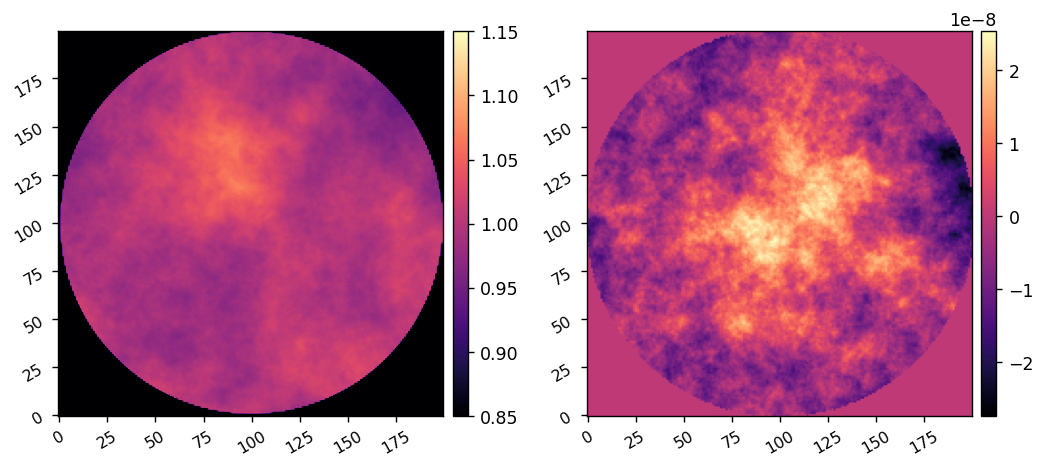

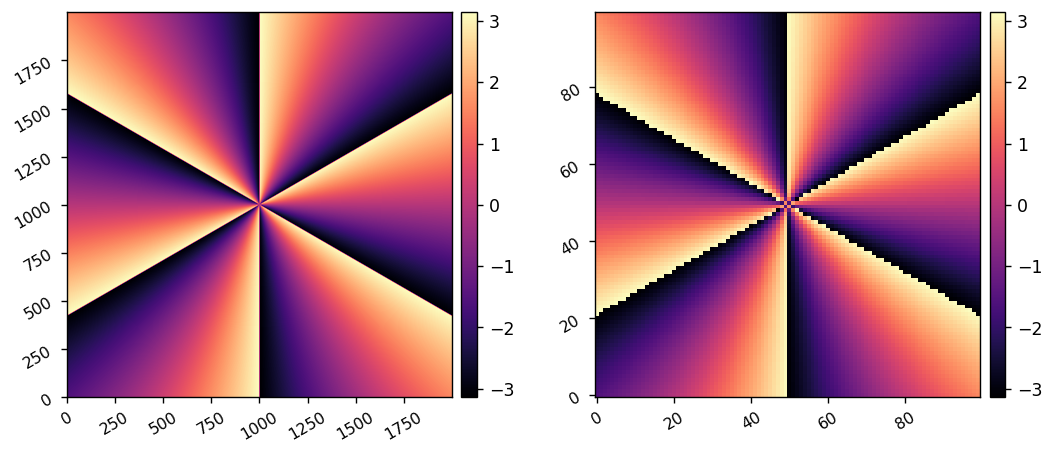

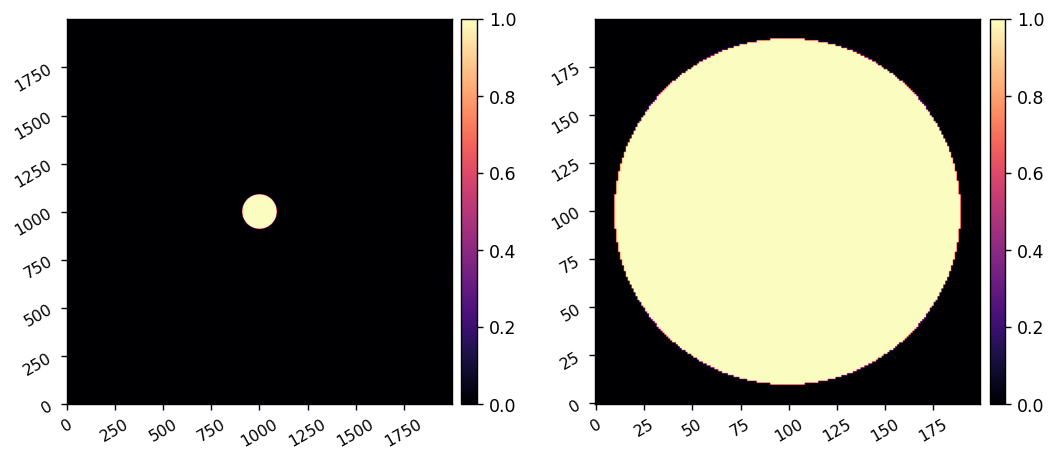

In [4]:
reload(cscoob)
reload(lina.utils)
WFE = lina.utils.generate_wfe(model.pupil_diam, wavelength=500*u.nm,
                                opd_index=2.8, amp_index=3.0, 
                                opd_seed=1234, amp_seed=12345,
                                opd_rms=17*u.nm, amp_rms=0.05,
                                npix=model.npix, oversample=model.oversample,
                                plot=True)
# model.WFE = WFE
# imshow2(xp.abs(WFE), xp.angle(WFE)/(2*np.pi)*model.wavelength.to_value(u.m), 
#         npix=model.npix,
#         vmin1=0.95)

VC = cscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
#                                    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)
imshow2(xp.angle(VC), xp.angle(scoobpsf.utils.pad_or_crop(VC, 100)))

LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
model.LYOT = LS
imshow2(LS, LS, npix2=model.npix)

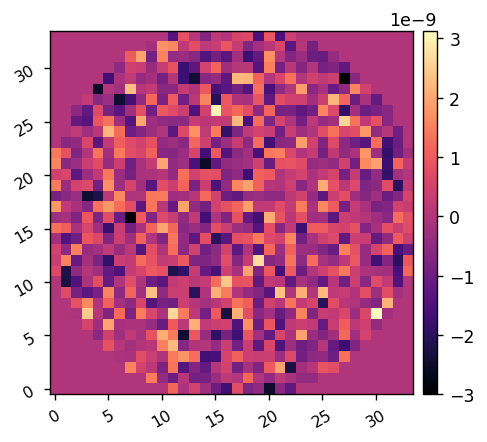

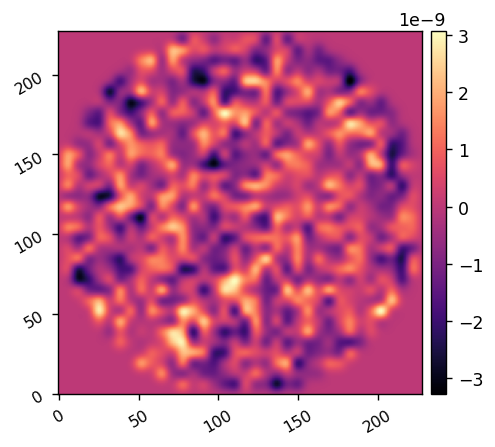

In [5]:
model.set_dm(np.random.randn(model.Nacts)*1e-9)
imshow1(model.get_dm())
imshow1(model.get_dm_surface())
model.reset_dm()

In [6]:
model.WFE = None
model.WFE = WFE

In [7]:
model.reset_dm()

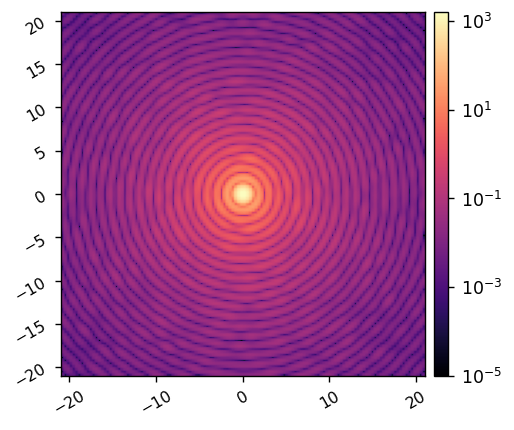

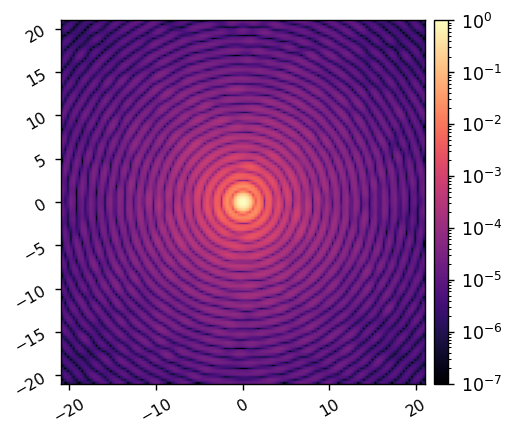

In [8]:
model.npsf = 128
model.FPM = None

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

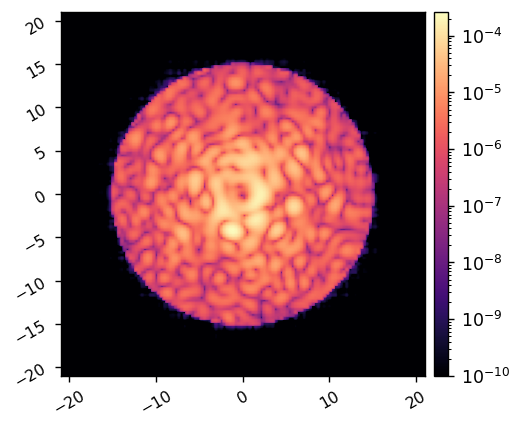

In [9]:
model.FPM = VC

model.FIELDSTOP = None
model.FIELDSTOP = model.focal_grid_pol[0]<15

image = model.snap(plot=True, vmin=1e-10)

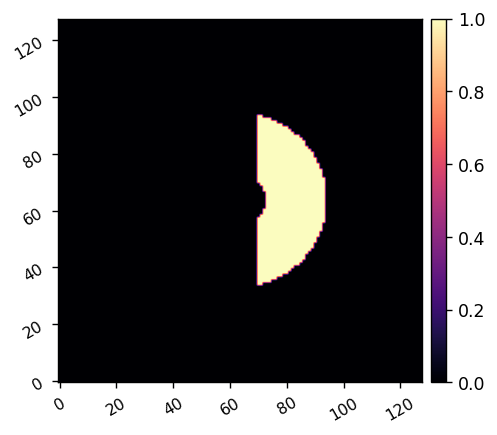

In [9]:
control_mask = lina.utils.create_annular_focal_plane_mask(model, 3, 10, 2, plot=True)

In [10]:
poke_modes = lina.utils.create_all_poke_modes(model.dm_mask)
response_matrix = lina.efc.calibrate(model, poke_modes, 1e-9, control_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=14.829 sec.
Jacobian built in 14.829 sec


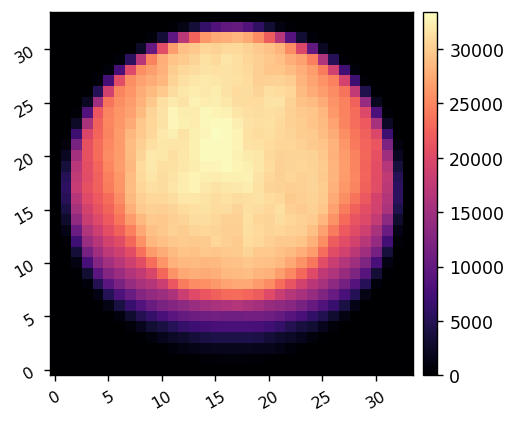

In [11]:
dm_response = xp.sqrt(xp.mean(xp.abs(response_matrix)**2, axis=0))
dm_response = model.DM.map_actuators_to_command(xp.asarray(dm_response))
imshow1(dm_response)

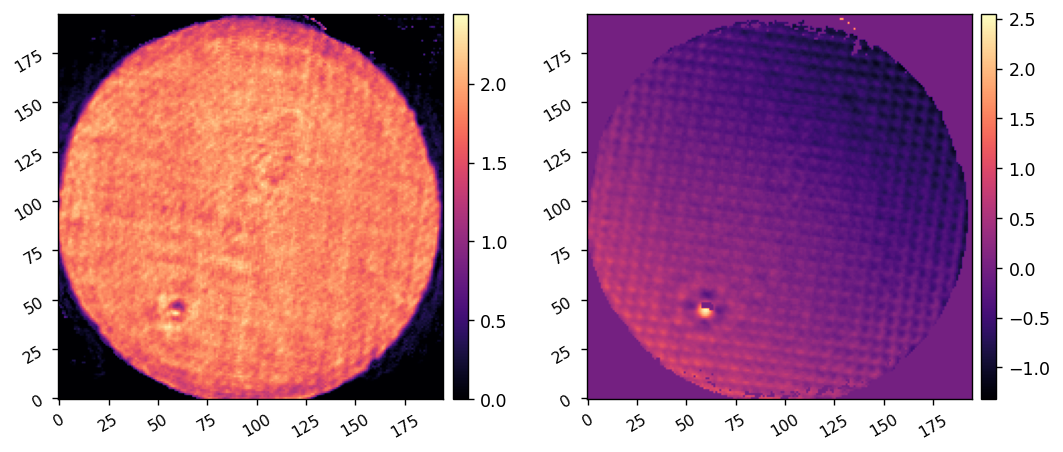

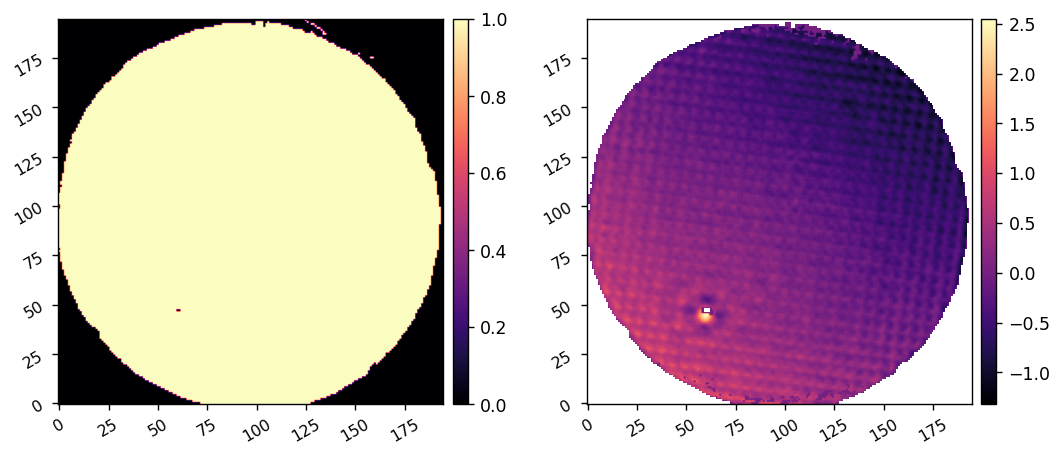

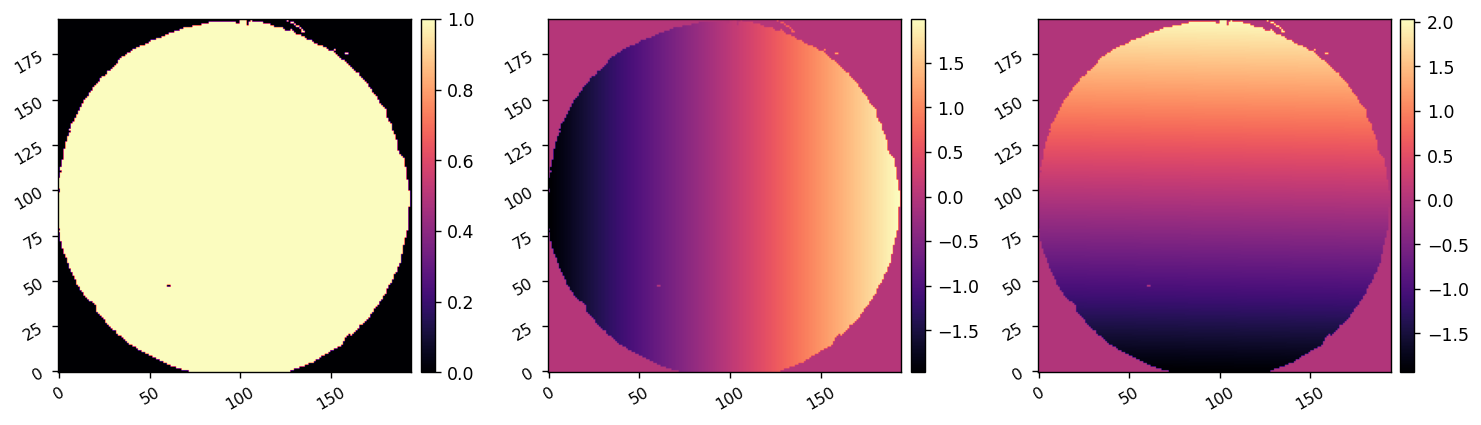

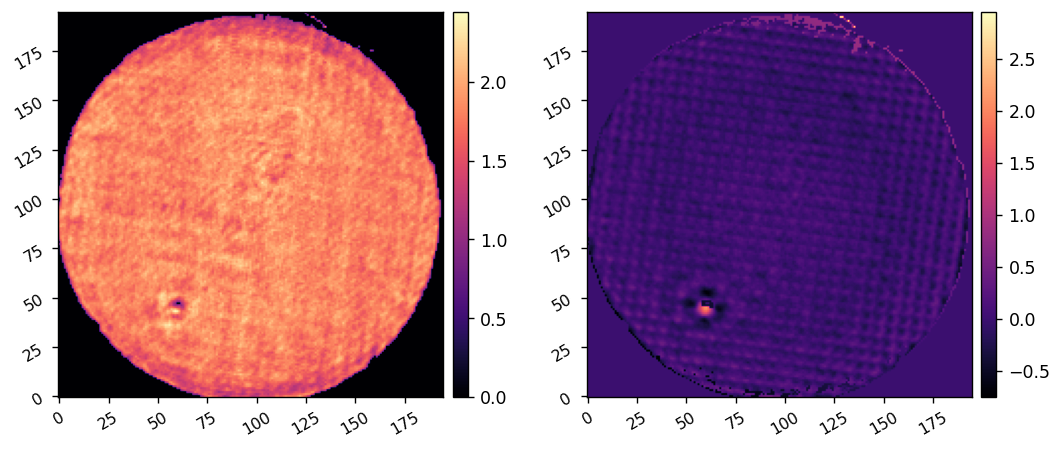

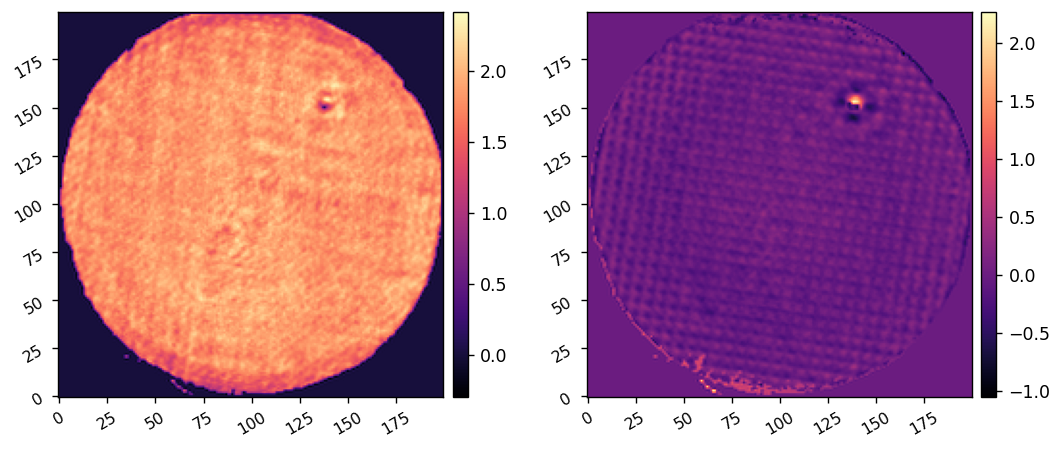

In [18]:
reload(scoobpsf.utils)

pr_rotation = 180 + model.det_rotation + 1
wfe = scoobpsf.utils.process_pr_data('amp_est_20230925.fits', 'phase_est_20230925.fits',
                             195, pr_rotation, pixelscale=6.75*u.mm/(model.npix*u.pix),
                             remove_modes=3)

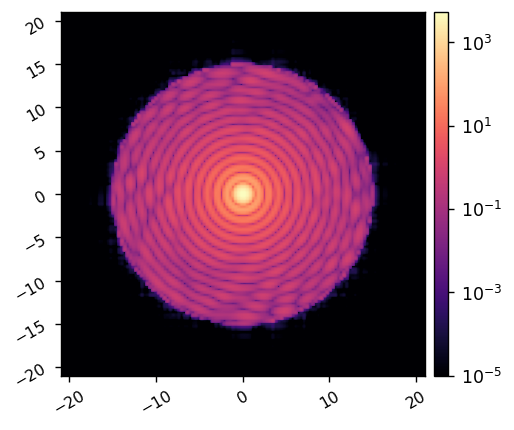

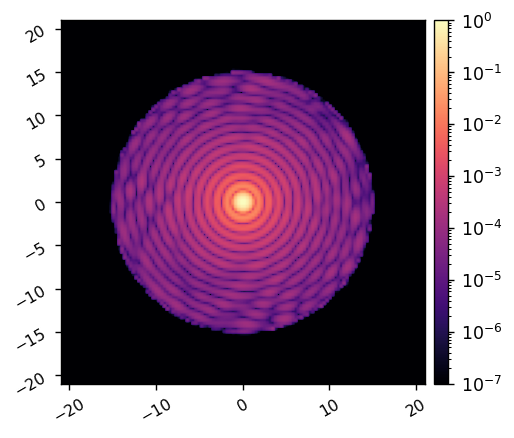

In [20]:
model.npsf = 128
model.WFE = scoobpsf.utils.pad_or_crop(wfe, model.N)
model.FPM = None

model.reset_dm()

model.Imax_ref = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)

model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

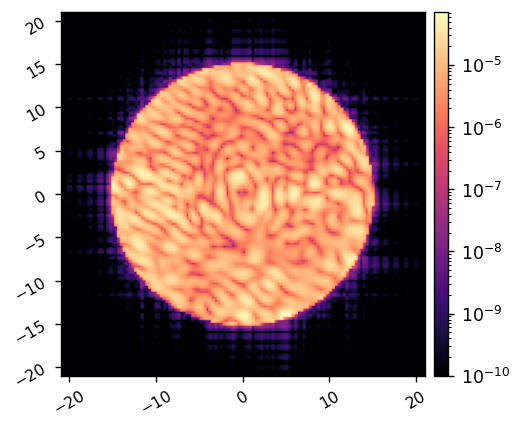

In [21]:
model.FPM = VC

model.FIELDSTOP = None
model.FIELDSTOP = model.focal_grid_pol[0]<15

image = model.snap(plot=True, vmin=1e-10)